# Checkpoint 1

**Due: Friday, 16 October, 2020 at 5:00pm BST**

### Read This First
1. Use the constants provided in the cell below. Do not use your own constants.

2. Put the code that produces the output for a given task in the cell indicated. You are welcome to add as many cells as you like for imports, function definitions, variables, etc. **Additional cells need to be in the proper order such that your code runs correctly the first time through.**

3. **IMPORTANT!** Before submitting your notebook, clear the output by clicking *Restart & Clear Output* from the *Kernel* menu. If you do not do this, the file size of your notebook will be very large.

## Libraries and Constants
Custom imports and constants should be added to a new cell.

In [45]:
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import animation, rc
%matplotlib inline
import numpy as np
from scipy import integrate, optimize
import time

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 16

# Gravitational constant
gg     = 6.67408e-11 # m^3 s^-1 kg^-2
# Lunar mass
mass   = 7.342e22 # kg
# Lunar radius
radius = 1738000 # m
# 1 day in seconds
day    = 3600*24 # seconds

### Initial positions and velocities at t=0
rs = [1842280, 0] # m
vs = [0, 1634]    # m/s

## Equations of motion for the unperturbed case:

$
\Large
\begin{align}
\frac{d^{2} x}{dt^2} = - \frac{G M x}{(x^2 + y^2)^{3/2}}
\end{align}
$

$
\Large
\begin{align}
\frac{d^{2} y}{dt^2} = - \frac{G M y}{(x^2 + y^2)^{3/2}}
\end{align}
$

# Task 1 (30p)

In the cell below, write a function that computes the trajectory from t = 0 to tmax, where tmax is given as an argument to the function. The function should return two arrays for the x and y positions of the trajectory. Each array should have N points (equally spaced in time), where N is given as an argument to the function. You may create additional cells for defining functions.

In [46]:
#import odeint for integration
from scipy.integrate import odeint

In [47]:
def function(state, time):
    """
    Defines function to be solved for trajectory
    
    Parameters
    ----------
    state : array
        points to be integrated
    time : array
        array of points in time
        
    Returns
    -------
    dx/dt : array
        horizontal velocity of trajectory
    dy/dt : array
        vertical velocity of trajectory
    ddxddt : array
        horizontal acceleration of the trajectory
    ddyddt : array
        vertical acceleration of the trajectory
        
    """
    xt, yt, dxdt, dydt = state
    z = np.power((np.power(xt, 2) + np.power(yt, 2)), 3/2)
    ddxddt = -(gg * mass * xt)/z
    ddyddt = -(gg * mass * yt)/z
    return dxdt, dydt, ddxddt, ddyddt
    

In [48]:
# Here I define times and initial values globally for later tasks
times = np.linspace(0,day,int(day / 100))
initial = [rs[0], rs[1], vs[0],  vs[1]]

def task1(N, tmax):
    """
    Compute orbital trajectory.
    
    Parameters
    ----------
    N : int
        Number of points in trajectory arrays
    tmax : float
        End time of integration in units of seconds.
        
    Returns
    -------
    x : array
        x positions of the trajectory
    y : array
        y positions of the trajectory
    """
    # Solves ODE
    values = odeint(function, initial, times, tfirst=False)
    #first column of the array are the x's
    x = values[:,0:1]
    #first column of the array are the x's
    y = values[:,1:2]
    return x, y

## Testing task 1

The cell below will run your function with inputs of tmax = 1 day (in seconds) and some number of points. The assert statements below will test that the returned arrays are the correct size.

In [49]:
t_max = day
n_points = int(t_max / 100)

x_pos, y_pos = task1(n_points, t_max)

assert x_pos.size == n_points
assert y_pos.size == n_points

# Task 1 continued

In the cell below, create an animation of the spacecraft's trajectory for t = 0 to 24 hours that includes a circle representing the Moon. Each frame of the animation should only show the last few points to avoid overlapping a previous orbit. A successful animation will be worth the full 30 points. Alternatively, create a static plot showing the Moon and the spacecraft's trajectory. This will be worth a maximum of 25 points.

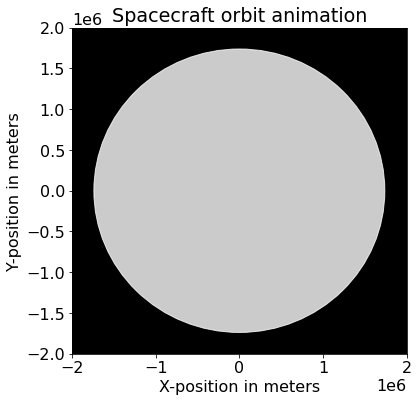

In [50]:
#intialize the plot
fig, ax = plt.subplots(figsize=(6, 6))

circle = plt.Circle((0, 0), radius, color='white', alpha=0.8)
ax.add_artist(circle)

ax.set_xlim(-2000000, 2000000)
ax.set_ylim(-2000000,2000000)
ax.set_title('Spacecraft orbit animation')
ax.set_xlabel('X-position in meters')
ax.set_ylabel('Y-position in meters')
ax.set_facecolor('xkcd:black')
# ax.set_facecolor((1.0, 0.47, 0.42))
line, = ax.plot([], [], lw=2)

plt.show()

In [51]:
# initialization function
def init():
    line.set_color('red')
    line.set_linewidth(5)
    line.set_data([], [])
    return (line,)

# animation function. This will be call in a sequence to generate frames.
def animate(i):
    x = np.linspace(0,day, n_points)
    x = x_pos
    y = y_pos
    z = np.sqrt(np.power(x_pos, 2) + np.power(y_pos, 2))
    # skip  some frames for faster runtime
    i = 4*i
    # specify start so that the line is animated and not overlap
    start = max(0, i - 20)
    line.set_data(x[start:i], y[start:i])
    return (line,)

In [52]:
#call the animator.  blit=True means only re-draw the parts that have changed.

# Uncomment to see animation

"""
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=250, interval=55, blit=True, repeat_delay =True)

HTML(anim.to_jshtml())

"""

'\nanim = animation.FuncAnimation(fig, animate, init_func=init,\n                               frames=250, interval=55, blit=True, repeat_delay =True)\n\nHTML(anim.to_jshtml())\n\n'

# Task 2 (15p)

Determine the orbital period T. Your solution must be calculated numerically, i.e., not simply using the analytical expression. The obtained value must be within +/-1 s of the correct value.

In the cell below, write a function that returns the orbital period in units of seconds.

In [53]:
def samesign(a, b):
        'returns true if a,b have the same sign'
        return a * b > 0

In [54]:
"""
Once the sign has changed 4 times the function has changed 4 quadrants
therefore has completed one period. At that stage I use a manual interpolation 
method to determine accurately where the function crosses the axis.
This is done by comparing the ratio of y_pos left and right from the axes
and assuming linearity to calculate the corresponding time inteval.
"""
def task2():
    'returns: orbital period in seconds'
    count = 0
    for index, (i,j) in enumerate(zip(y_pos, times)):
        if not samesign(i, y_pos[index -1]):
            count +=1
        if count == 4: 
            frac = 100*((np.abs(y_pos[index -1])) / (np.abs(y_pos[index -1]) + y_pos[index]))
            period = times[index -1] + frac
            break
    
    return(period)

## Testing task 2

The cell below will run your function and compare with the analytic answer. They should agree to within 1 second.

In [55]:
T_calc = task2()
t1 = time.time()
print (f"Calculated orbital period: {T_calc} seconds.")
t2 = time.time()

mu = gg * mass
T_analytic = 2 * np.pi * np.sqrt((rs[0]**3 * mu**2) / (2*mu - rs[0]*vs[1]**2)**3)

print (f"Difference with correct answer: {T_calc - T_analytic} seconds.")
print (f"Solution calculated in {t2-t1} seconds.")

assert abs(T_calc - T_analytic) <= 1

print ("Hooray!")

Calculated orbital period: [7138.37339125] seconds.
Difference with correct answer: [-0.02603354] seconds.
Solution calculated in 0.0002770423889160156 seconds.
Hooray!


# Task 3 (20p)

Now add a correction that makes the gravitational field non-spherical. The correction rotates with the Moon (one full rotation every T$_{Moon}$ = 27.3 days). How long does it take until the spacecraft hits the Moon? The time must be accurate to +/-1 s. Assume the Moon’s surface is a sphere. The equations of motion now become:

$
\Large
\begin{align}
\frac{d^{2} x}{dt^2} = - \frac{G M x}{(x^2 + y^2)^{3/2}}
- \frac{q\ G M x^\prime}{(x^{^\prime2} + y^{^\prime2})^{3/2}}
\end{align}
$

$
\Large
\begin{align}
\frac{d^{2} y}{dt^2} = - \frac{G M y}{(x^2 + y^2)^{3/2}}
- \frac{q\ G M y^\prime}{(x^{^\prime2} + y^{^\prime2})^{3/2}}
\end{align}
$

$
\Large
\begin{align}
x^\prime = x + 0.8\ R \cos \left( \frac{2 \pi t}{T_{Moon}} \right)
\end{align}
$

$
\Large
\begin{align}
y^\prime = y + 0.8\ R \sin \left( \frac{2 \pi t}{T_{Moon}} \right)
\end{align}
$

where q = 0.00025.

## Task 3 objectives:
1. Compute the time at which the spacecraft hits the Moon.
2. Make a plot of the height of the spacecraft above the Moon's surface as a function of time. Don't forget to label axes and include units.

In [56]:
def function2(state, time):
    """
    Defines function to be solved for perturbed trajectory
    
    Parameters
    ----------
    state : array
        points to be integrated
    time : array
        array of points in time
        
    Returns
    -------
    dx/dt : array
        horizontal velocity of trajectory
    dy/dt : array
        vertical velocity of trajectory
    ddxddt : array
        horizontal acceleration of the trajectory
    ddyddt : array
        vertical acceleration of the trajectory
        
    """
    q = 0.00025
    T_moon = 27.3 * day
    xt, yt, dxdt, dydt = state
    xpt = xt + 0.8 * radius * np.cos((2 * np.pi * time)/ T_moon)
    ypt = yt + 0.8 * radius * np.sin((2 * np.pi * time)/ T_moon)
    z = np.power((np.power(xt, 2) + np.power(yt, 2)), 3/2)
    zp = np.power((np.power(xpt, 2) + np.power(ypt, 2)), 3/2)
    ddxddt = -(gg * mass * xt)/z -(q * gg * mass * xpt)/zp
    ddyddt = -(gg * mass * yt)/z -(q * gg * mass * ypt)/zp
    return dxdt, dydt, ddxddt, ddyddt

# Task 3 part 1

In the cell below, create a function that returns the impact time accurate to within 1 second.

In [57]:
T_moon = 27.3 * day
# Decreased the time step in order to calculate most accurate result.
times = np.linspace(0,T_moon/2 ,int(T_moon / 3))
initial = [rs[0], rs[1], vs[0],  vs[1]]

# I just make the same calculation globally so that I can use 
# the results on a later task. If we had more freedom to choose
# what task3() returns I would include everything in the function.
values2 = odeint(function2, initial, times)
x_pos2 = values2[:,0]
y_pos2 = values2[:,1]
position = np.power((np.power(x_pos2, 2) + np.power(y_pos2, 2)), 1/2)

def task3():
    'returns: impact time in seconds'
    #calculates values for perturbed case
    values2 = odeint(function2, initial, times)
    x_pos2 = values2[:,0]
    y_pos2 = values2[:,1]
    position = np.power((np.power(x_pos2, 2) + np.power(y_pos2, 2)), 1/2)
    
    
    for index, (i,j) in enumerate(zip(position, times)):
        # Once the position becomes smaller than 
        # the radius of moon, it means we have impact.
        if abs(i) <= radius:
            new_time = j
            break
    return(new_time)
    

## Testing task 3 part 1

The cell below will run your function and print your answer. This will be tested against the correct answer (not given).

In [58]:
t1 = time.time()
t_impact = task3()
t2 = time.time()

print (f"Time to impact: {t_impact:.2f} seconds ({t_impact / day:.2f} days).")
print (f"Solution calculated in {t2-t1} seconds.")

Time to impact: 627060.80 seconds (7.26 days).
Solution calculated in 1.0188770294189453 seconds.


## Task 3 part 2

In the cell below, plot of the height of the spacecraft above the Moon's surface as a function of time. Don't forget to label axes and include units.

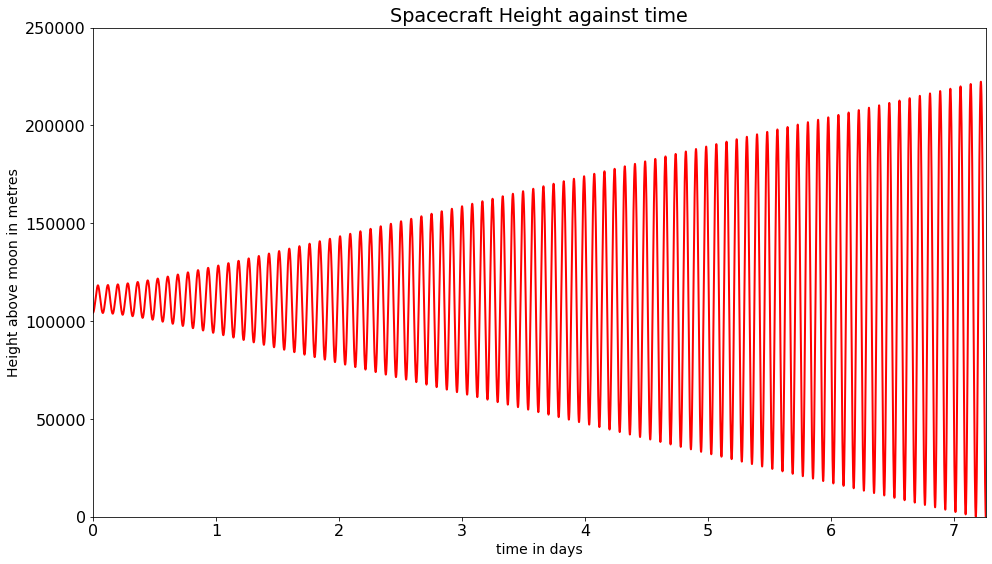

In [59]:
# Initiallize plot
fig, ax = plt.subplots(figsize=(16, 9))

# Divide by days to see clearly on which day it reaches 0
x = times/day
y = position - radius

ax.plot(x, y, linestyle='-', linewidth=2, color='red')
ax.xaxis.set_label_text('time in days', fontsize=14)
ax.yaxis.set_label_text('Height above moon in metres', fontsize=14)
ax.set_ylim(0, 250000)
ax.set_title('Spacecraft Height against time')
# Stop the plot at the impact
ax.set_xlim(0, t_impact / day)

plt.show()

# Task 4 (10p)

Which coordinate (x or y) of the position of the spacecraft after one revolution (orbital period T from task 2) is more sensitive to small changes in the amplitude of the correction? To answer this, calculate the derivatives of dx/dq and dy/dq at t = T, for q = 0. Write your answer in the cell below, describing how you arrived at it. Place any code that demonstrates your solution in the cell with the function called `task4`.

YOUR ANSWER HERE

Y is more sensitive to small changes in the amplitude of the correction by a factor of 347.7


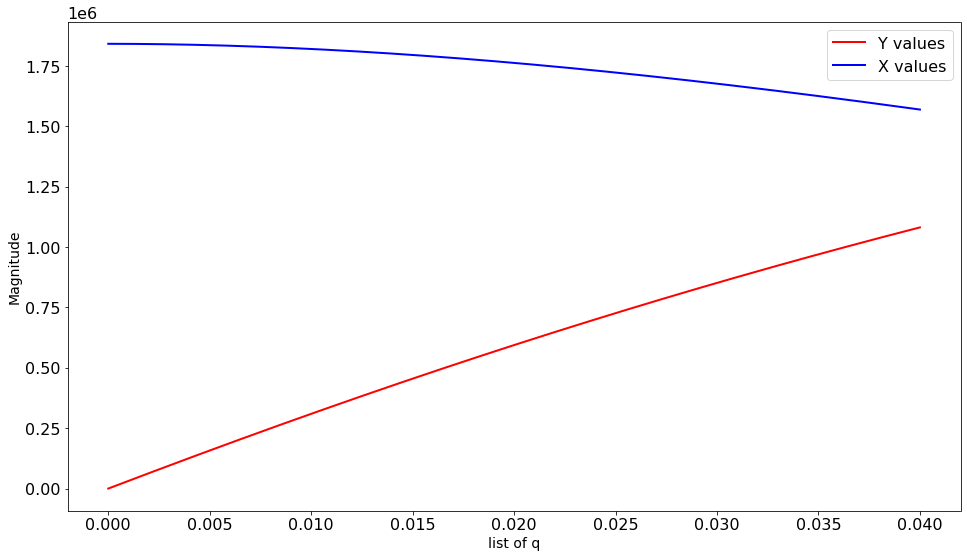

In [60]:
def function3(state, time, q):
    """
    Defines function to be solved ODE perturbed trajectory including a q argument
    
    Parameters
    ----------
    state : array
        points to be integrated
    time : array
        array of points in time
    q : float
        value determining the scale of pertrubation
        
    Returns
    -------
    dx/dt : array
        horizontal velocity of trajectory
    dy/dt : array
        vertical velocity of trajectory
    ddxddt : array
        horizontal acceleration of the trajectory
    ddyddt : array
        vertical acceleration of the trajectory
        
    """
    
    T_moon = 27.3 * day
    xt, yt, dxdt, dydt = state
    xpt = xt + 0.8 * radius * np.cos((2 * np.pi * time)/ T_moon)
    ypt = yt + 0.8 * radius * np.sin((2 * np.pi * time)/ T_moon)
    z = np.power((np.power(xt, 2) + np.power(yt, 2)), 3/2)
    zp = np.power((np.power(xpt, 2) + np.power(ypt, 2)), 3/2)
    ddxddt = -(gg * mass * xt)/z -(q * gg * mass * xpt)/zp
    ddyddt = -(gg * mass * yt)/z -(q * gg * mass * ypt)/zp
    return dxdt, dydt, ddxddt, ddyddt

def orbit_T(q, t):
    """
    Solves ODE for perturbed trajectory
    
    Parameters
    ----------
    q : array
        points to be integrated
    t : array
        array of points in time
        
    Returns
    -------
    x_pos2[-1] : float
        last x-position of trajectory
    y_pos2[-1] : float
        last y-position of trajectory
        
    """
    values = odeint(function3, initial, t, args=(q,))
    x_pos2 = values[:,0]
    y_pos2 = values[:,1]
    return(x_pos2[-1], y_pos2[-1])   


def task4():
    # creates an array of q vlues
    list_of_q = np.linspace(0,0.04,200) 
    xs_array = np.zeros(len(list_of_q))
    ys_array = np.zeros(len(list_of_q))
    # linspace created until impact (Tcalc[0])
    times_T = np.linspace(0,T_calc[0] ,int(T_calc[0]/200))
    
    t1 = time.time()

    for i ,j in enumerate(list_of_q):
        values3 = orbit_T(j, times_T)
        #populate arrays for different q's
        xs_array[i] = values3[0]
        ys_array[i] = values3[1]

    t2 = time.time()
    
    # direct calculation of derivatives
    dx_dq = (xs_array[1] - xs_array[0])/(list_of_q[1] - list_of_q[0])
    dy_dq = (ys_array[1] - ys_array[0])/(list_of_q[1] - list_of_q[0])
    factor = abs(dx_dq/dy_dq)
    
    # Since the value of the derivative determines how sensitive X and Y are to changes
    # of q, the factor will determine which is larger.
    
    if(factor > 1):
        print('X is more sensitive to small changes \
in the amplitude of the correction by a factor of {:.1f}'.format(factor))
    elif(factor < 1):
        print('Y is more sensitive to small changes \
in the amplitude of the correction by a factor of {:.1f}'.format(1/factor))
    else:
        print('X and Y are equally sensitive to small \
changes in the amplitude of the correction')
    
    # This plot shows that for the range of q values we are considering it suffices to
    # measure the gradient at the start of the curve and conclude which of 
    # the dX/dq,dY/dq is larger.
    fig, ax = plt.subplots(figsize=(16, 9))
    x = list_of_q
    y1 = ys_array
    y2 = xs_array
    
    ax.plot(x, y1, linestyle='-', linewidth=2, color='red', label = 'Y values')
    ax.plot(x, y2, linestyle='-', linewidth=2, color='blue', label = 'X values')
    ax.xaxis.set_label_text('list of q', fontsize=14)
    ax.yaxis.set_label_text('Magnitude', fontsize=14)
    ax.legend()
    plt.show()
    
task4()

# Task 5 (10p)

The positions of the spacecraft at t=0, t=T/2, and t=T are given in the cell below. Use them to determine the amplitude of the correction q. Note, this is a different value than for the previous tasks.

A comment for those interested in space science: this is a highly simplified and unrealistic version of the task NASA scientists had to carry out to map out the gravity at the Moon's surface using "telemetry" data (positions and velocities) of various spacecrafts orbiting the Moon.

Put your code in the cell that starts with `def task5():`.

Your answer should be within 20% of the correct answer.

In [61]:
r1 = [1842280.0, 0.0]
r2 = [-1856332.7223839264, -717.5195460640389]
r3 = [1842271.070055315, 3847.378923359429]

In [62]:
def orbit_T2(q, t):
    """
    Solves ODE for perturbed trajectory
    
    Parameters
    ----------
    q : array
        points to be integrated
    t : array
        array of points in time
        
    Returns
    -------
    x_pos2[T2_ind] : float
        x position at t = T/2
    y_pos2[T2_ind] : float
        y position at t = T/2
    x_pos2[-1] : 
        x position at t = T
    y_pos2[-1] : 
        y position at t = T
        
    """
    values = odeint(function3, initial, t, args=(q,))
    x_pos2 = values[:,0]
    y_pos2 = values[:,1]
    #index at half the period 
    T2_ind = int(len(x_pos2)/2)
    return(x_pos2[T2_ind], y_pos2[T2_ind], x_pos2[-1], y_pos2[-1] ) 


def task5():
    
    # linspace until impact T
    times_T = np.linspace(0,T_calc[0] ,int(T_calc[0]/200))
    # linspace of trial values of q
    list_of_q2 = np.linspace(0.0001,0.0003,200) 
    
    # create arrays for x and y positions at T and T/2
    xs_array_T2 = np.zeros(len(list_of_q2))
    ys_array_T2 = np.zeros(len(list_of_q2))
    xs_array_T = np.zeros(len(list_of_q2))
    ys_array_T = np.zeros(len(list_of_q2))
    
    for i ,j in enumerate(list_of_q2):
        # enumerates through a list of q's and stores corresponding x and y 
        # positions at each q. These are taken from time T/2 and T to 
        # compare with the given r1, r2, r3
        values4 = orbit_T2(j, times_T)
        xs_array_T2[i] = values4[0]
        ys_array_T2[i] = values4[1]
        xs_array_T[i] = values4[2]
        ys_array_T[i] = values4[3]
        
    # These minima correspond to the cases where x and y positions 
    # where the closest to the given r1, r2, r3
    min_x_T2 =abs(xs_array_T2 - r2[0])
    min_y_T2 =abs(ys_array_T2 - r2[1])
    min_x_T =abs(xs_array_T - r3[0])
    min_y_T =abs(ys_array_T - r3[1])
    
    # Takes the corresponding index of minimum
    index_x_T2 = np.argmin(min_x_T2)
    index_y_T2 = np.argmin(min_y_T2)
    index_x_T = np.argmin(min_x_T)
    index_y_T = np.argmin(min_y_T)

    # Finds the corresponding q to that x and y position.
    q1 = list_of_q2[index_x_T2]
    q2 = list_of_q2[index_y_T2]
    q3 = list_of_q2[index_x_T]
    q4 = list_of_q2[index_y_T]
    
    # Group and average for the most reliable result
    all_q = np.arange(q1,q2,q3,q4)
    q_average = np.mean(all_q)
    return(q_average)

## Testing task 5

The cell below will run your function and print your answer. This will be tested against the correct answer (not given). Your answer should be within 20% of the correct answer.

In [63]:
t1 = time.time()
mystery_q = task5()
t2 = time.time()

print (f"q = {mystery_q}")
print (f"Solution calculated in {t2-t1} seconds.")


q = 0.00012010050251256282
Solution calculated in 1.0627400875091553 seconds.


# Task 6 (15p)

What is the minimum initial height of a circular orbit such that, for the perturbation from task 3 (q = 0.00025), the spacecraft does not collide with the Moon but remains gravitationally bound to it?

The orbit may still show oscillations as in task 3, but the spacecraft cannot not hit the lunar surface.

Create a function `task6` that returns the minimum height of the circular orbit in units of meters. Explain your approach. To obtain full marks, the answer must be correct to +/-1 km.

The following formula for the velocity of a point mass in circular orbit of radius r, orbiting a spherically symmetric body of mass M, may be useful:

$
\Large
\begin{align}
v_{c} = \sqrt{\frac{G\ M}{r}}.
\end{align}
$

In the cell below, create a function that calculates the minimum height of a stable orbit in units of meters. Your answer should be within 1000 meters of the correct answer.

In [64]:
def norm(x,y):
    # Returns the norm of vectors x, y.
    return np.sqrt(np.power(x,2) + np.power(y,2))

def vel_func(r):
    # Calculates the velocity of spacecraft for given r
    return np.sqrt((gg * mass)/r)

def task6():
    # Trial values for possible initial heights. These were chosen after trial and error to
    # find the exact place it first avoids the crush and the orbit is bound.
    possible_rs = np.linspace(1890000, 1910000, 20)
    # Calculates the velocities for the initial conditions above
    possible_vs = [vel_func(r) for r in possible_rs]
    
    # Again this was chosen with trial and error. It amounts for about 100 days.
    # It is enough to check that for the possible rs's it does crush at some points
    # and not very large that would be computationally and time expensive. It is 
    # enough to find the first stable orbit that is bound.
    times = np.linspace(0,7*(T_moon/2) ,int(7*(T_moon / 200)))

    for index, (i,j) in enumerate(zip(possible_rs, possible_vs)):
        # Set initial values
        initial = [i,0,0,j]
        # Solve ODE
        values4 = odeint(function2, initial, times)
        xpos = values4[:,0]
        ypos = values4[:,1]

        zpos = []
        # Caltulates r position for each xpos, ypos
        for j in range(len(xpos)):
            z = norm(xpos[j], ypos[j])
            zpos.append(z)
        
        # If the minimum value of the r positions is smaller than the radius of the 
        # moon, it means that it has crushed at some point.
        if np.amin(zpos) < radius:
            print('crushed on the moon with initial r: {}'.format(i))
            pass
        else:
            print('did not crush with initial r: {}'.format(i))
            min_r = i

            plt.plot(times, zpos)
            plt.title('Position (m) of spacecraft away from \
the \n centre of the moon against time (s)')
            plt.show
            break
    # subtract the value of radius to find height above moon.
    min_height = min_r - radius
    return min_height
          

## Testing task 6

The cell below will run your function and print your answer. This will be tested against the correct answer (not given). Your answer should be within 1000 meters of the correct answer.

crushed on the moon with initial r: 1890000.0
crushed on the moon with initial r: 1891052.6315789474
crushed on the moon with initial r: 1892105.2631578948
did not crush with initial r: 1893157.894736842
Minimum height of stable orbit: 155157.89473684202 m.
Solution calculated in 19.263102293014526 seconds.


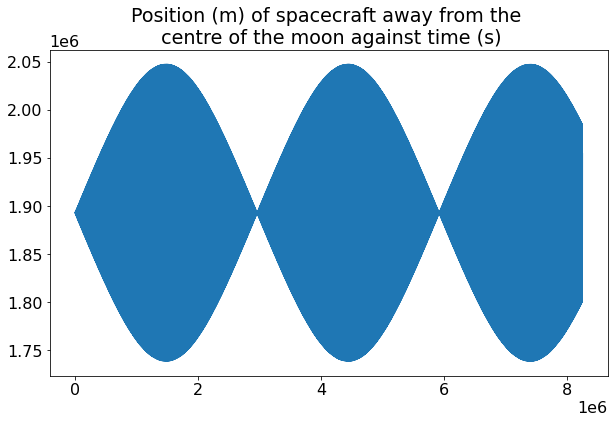

In [65]:
t1 = time.time()
min_height = task6()
t2 = time.time()
print (f"Minimum height of stable orbit: {min_height} m.")
print (f"Solution calculated in {t2-t1} seconds.")


In [66]:
# This plot demonstrates that the values of the position change 
# periodically. This suggests that it is a bound orbit. I understand that this
# is not sufficient for the infinite case but since we have a numerical 
# solution it would be impossible to have a graph that has overall gradient decrease of 0.
